<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp02_Epoch_params_t_SNE_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum to mean
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

* ✅ Check Point
    * Just try it again...!
    * 
    * 
    
## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Fri Jul  3 15:22:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [8]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [10]:
print(train_dataset.dataset)
print(test_dataset.dataset)

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )


In [11]:
type(test_dataset)

torch.utils.data.dataset.Subset

In [12]:
'''
for idx, (data, _) in enumerate(test_dataset):
    if idx == 5: 
        break
    else:
        print(data, _)
'''

'\nfor idx, (data, _) in enumerate(test_dataset):\n    if idx == 5: \n        break\n    else:\n        print(data, _)\n'

In [13]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset

test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [14]:
# for idx, (data, _) in enumerate(train_loader):
#     print(data[3], data[4], data.type(), data.shape)
#     print(_, _.type())
#     print("==" * 20 )

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [16]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 2, 17,  3,  3,  3,  9, 13,  2,  2,  2,  2,  3,  2,  4,  2,  3])


In [17]:
'''
for batch_idx, (data, _) in enumerate(train_loader):
    print(data.shape, _.shape)
    if batch_idx == 5:
        break
'''

'\nfor batch_idx, (data, _) in enumerate(train_loader):\n    print(data.shape, _.shape)\n    if batch_idx == 5:\n        break\n'

In [18]:
'''
for batch_idx, (data, _) in enumerate(test_loader_10):
    print(data.shape, _.shape)
 '''

'\nfor batch_idx, (data, _) in enumerate(test_loader_10):\n    print(data.shape, _.shape)\n '

torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Allaple.A Obfuscator.AD Allaple.L Allaple.L Allaple.L Dontovo.A Lolyda.AA2 Allaple.A Allaple.A Allaple.A Allaple.A Allaple.L Allaple.A Alueron.gen!J Allaple.A Allaple.L 


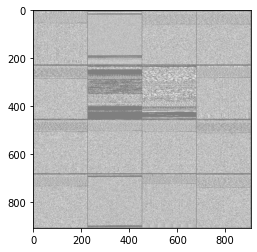

In [19]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [20]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [21]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [27]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))


In [28]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='mean')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
def test(epoch):
    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    if epoch % 10 == 0:  # Epoch이 10의 배수일때

        # save model.state_dict() per 10 Epochs
        torch.save(model.state_dict(), ('./Again_Exp02_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

        # load_whole test_data 
        for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
        # save latent_vector per 10 Epochs
            latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                              # latent_vector_size: (num_of_data, 100)
            color_palette = _.detach().cpu().clone().numpy()
            with open((str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
                np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                        # 10 Epoch 단위로 latent vector를 저장한다
                                        # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다

        # plot latent vector Every 10 Epochs
        # t-SNE for Dimensionality reduction
        Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

        x = Z_embedded[:, 0]
        y = Z_embedded[:, 1]
        label = color_palette
        # label[10:12] = 0  # make sure there are some 0 values to show up as grey

        tsne_data = np.vstack(Z_embedded, label)
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
        sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
        plt.savefig('./' + str(epoch) + '_t_SNE.png', dpi=300)
        plt.show()
    
    elif epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './results_02/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


1
Train Epoch: 1 [0/7471 (0%)]	Loss: 35145.332031
Train Epoch: 1 [160/7471 (2%)]	Loss: 48862.609375
Train Epoch: 1 [320/7471 (4%)]	Loss: 38802.957031
Train Epoch: 1 [480/7471 (6%)]	Loss: 40073.941406
Train Epoch: 1 [640/7471 (9%)]	Loss: 39276.570312
Train Epoch: 1 [800/7471 (11%)]	Loss: 39429.335938
Train Epoch: 1 [960/7471 (13%)]	Loss: 39018.453125
Train Epoch: 1 [1120/7471 (15%)]	Loss: 41106.097656
Train Epoch: 1 [1280/7471 (17%)]	Loss: 40007.214844
Train Epoch: 1 [1440/7471 (19%)]	Loss: 37535.230469
Train Epoch: 1 [1600/7471 (21%)]	Loss: 38244.585938
Train Epoch: 1 [1760/7471 (24%)]	Loss: 37699.675781
Train Epoch: 1 [1920/7471 (26%)]	Loss: 37574.757812
Train Epoch: 1 [2080/7471 (28%)]	Loss: 46542.839844
Train Epoch: 1 [2240/7471 (30%)]	Loss: 68721.929688
Train Epoch: 1 [2400/7471 (32%)]	Loss: 70860.820312
Train Epoch: 1 [2560/7471 (34%)]	Loss: 65833.773438
Train Epoch: 1 [2720/7471 (36%)]	Loss: 72633.890625
Train Epoch: 1 [2880/7471 (39%)]	Loss: 66876.117188
Train Epoch: 1 [3040/747

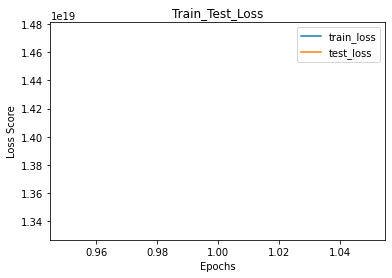

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 68511.429688
Train Epoch: 2 [160/7471 (2%)]	Loss: 676183.500000
Train Epoch: 2 [320/7471 (4%)]	Loss: 130636.000000
Train Epoch: 2 [480/7471 (6%)]	Loss: 117445.062500
Train Epoch: 2 [640/7471 (9%)]	Loss: 53395.101562
Train Epoch: 2 [800/7471 (11%)]	Loss: 52379.859375
Train Epoch: 2 [960/7471 (13%)]	Loss: 44814.738281
Train Epoch: 2 [1120/7471 (15%)]	Loss: 43081.835938
Train Epoch: 2 [1280/7471 (17%)]	Loss: 44024.937500
Train Epoch: 2 [1440/7471 (19%)]	Loss: 43048.390625
Train Epoch: 2 [1600/7471 (21%)]	Loss: 44818.093750
Train Epoch: 2 [1760/7471 (24%)]	Loss: 44998.500000
Train Epoch: 2 [1920/7471 (26%)]	Loss: 43983.195312
Train Epoch: 2 [2080/7471 (28%)]	Loss: 43893.031250
Train Epoch: 2 [2240/7471 (30%)]	Loss: 49311.312500
Train Epoch: 2 [2400/7471 (32%)]	Loss: 45174.773438
Train Epoch: 2 [2560/7471 (34%)]	Loss: 50860.882812
Train Epoch: 2 [2720/7471 (36%)]	Loss: 67675.000000
Train Epoch: 2 [2880/7471 (39%)]	Loss: 54907.679688
Train Epoch: 2 [3040/

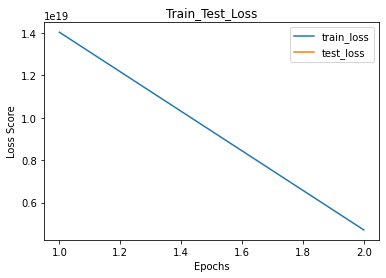

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 51070.769531
Train Epoch: 3 [160/7471 (2%)]	Loss: 48971.531250
Train Epoch: 3 [320/7471 (4%)]	Loss: 50503.804688
Train Epoch: 3 [480/7471 (6%)]	Loss: 54942.277344
Train Epoch: 3 [640/7471 (9%)]	Loss: 55023.992188
Train Epoch: 3 [800/7471 (11%)]	Loss: 65763.695312
Train Epoch: 3 [960/7471 (13%)]	Loss: 51506.351562
Train Epoch: 3 [1120/7471 (15%)]	Loss: 56303.132812
Train Epoch: 3 [1280/7471 (17%)]	Loss: 50115.109375
Train Epoch: 3 [1440/7471 (19%)]	Loss: 52092.773438
Train Epoch: 3 [1600/7471 (21%)]	Loss: 49555.109375
Train Epoch: 3 [1760/7471 (24%)]	Loss: 83400.640625
Train Epoch: 3 [1920/7471 (26%)]	Loss: 58275.605469
Train Epoch: 3 [2080/7471 (28%)]	Loss: 56021.101562
Train Epoch: 3 [2240/7471 (30%)]	Loss: 53377.710938
Train Epoch: 3 [2400/7471 (32%)]	Loss: 90266.460938
Train Epoch: 3 [2560/7471 (34%)]	Loss: 56381.960938
Train Epoch: 3 [2720/7471 (36%)]	Loss: 55522.222656
Train Epoch: 3 [2880/7471 (39%)]	Loss: 52988.121094
Train Epoch: 3 [3040/747

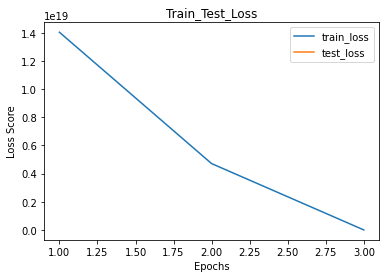

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 55838.140625
Train Epoch: 4 [160/7471 (2%)]	Loss: 84566.734375
Train Epoch: 4 [320/7471 (4%)]	Loss: 58728.828125
Train Epoch: 4 [480/7471 (6%)]	Loss: 94566.484375
Train Epoch: 4 [640/7471 (9%)]	Loss: 58752.242188
Train Epoch: 4 [800/7471 (11%)]	Loss: 59668.992188
Train Epoch: 4 [960/7471 (13%)]	Loss: 54462.789062
Train Epoch: 4 [1120/7471 (15%)]	Loss: 54252.382812
Train Epoch: 4 [1280/7471 (17%)]	Loss: 54081.855469
Train Epoch: 4 [1440/7471 (19%)]	Loss: 53795.039062
Train Epoch: 4 [1600/7471 (21%)]	Loss: 55380.046875
Train Epoch: 4 [1760/7471 (24%)]	Loss: 58954.136719
Train Epoch: 4 [1920/7471 (26%)]	Loss: 55240.750000
Train Epoch: 4 [2080/7471 (28%)]	Loss: 53648.941406
Train Epoch: 4 [2240/7471 (30%)]	Loss: 73297.609375
Train Epoch: 4 [2400/7471 (32%)]	Loss: 60032.179688
Train Epoch: 4 [2560/7471 (34%)]	Loss: 91475.562500
Train Epoch: 4 [2720/7471 (36%)]	Loss: 66936.281250
Train Epoch: 4 [2880/7471 (39%)]	Loss: 174725.937500
Train Epoch: 4 [3040/74

RuntimeError: ignored

In [29]:
epochs = 200

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_02/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './results_02/sample_' + str(epoch) + '.png')